In [1]:
# Import the necessary libraries:
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category = UndefinedMetricWarning)

import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from xgboost import XGBClassifier
from joblib import dump, load

In [2]:
def import_dataset(file_path):
    
    #Import the dataset from a CSV file.

    print("--------------- Importing Dataset ---------------\n")
    try:
        dataset = pd.read_csv(file_path)
        print("Successfully Imported 'csv' file!\n")
        return dataset
    
    except Exception as e:
        print(f"Error occurred while importing dataset: {e}")    
        return None

In [3]:
data = import_dataset('sampled_file_100k.csv')

--------------- Importing Dataset ---------------

Successfully Imported 'csv' file!



In [4]:
def convert_jail_to_binary(dataset):

    #Convert the 'jail' column of the dataset into a binary format.

    print("------------- Converting 'jail' to binary -------------\n")

    if 'jail' not in dataset.columns:
        print("Error: 'jail' column not found in the dataset.")
        return dataset

    # Convert the 'jail' column to binary
    # Any non-zero value in 'jail' is set to 1, and zero remains 0
    dataset['jail'] = dataset['jail'].apply(lambda x: 1 if x > 0 else 0)

    print("Successfull :)")
    return dataset

In [5]:
data = convert_jail_to_binary(data)

------------- Converting 'jail' to binary -------------

Successfull :)


In [6]:
def preprocess_data(dataset, target_column, feature_columns=None):
    
    #Preprocess the dataset by defining the target and features.
    print("--------------- Preprocessing ---------------\n")

    # If feature_columns is not provided, use all columns except the target
    if feature_columns is None:
        feature_columns = [col for col in dataset.columns if col != target_column]

    # Separate the features (X) and the target (y)
    X = dataset[feature_columns]
    y = dataset[target_column]
  
    # Displaying information about the features and target
    print(f"Total number of features (X): {len(feature_columns)}")
    print(f"Feature names: {feature_columns}")
    print(f"\nTarget variable (y): {target_column}")

    return X, y

In [7]:
# Preprocess the data
target_column = 'jail'  # This is the column we want to predict
X_features, y_target_variable = preprocess_data(data, target_column)

--------------- Preprocessing ---------------

Total number of features (X): 18
Feature names: ['county', 'new_id', 'sex', 'race', 'judge_id', 'case_type', 'offence_category', 'age_offense', 'age_judge', 'prior_felony', 'prior_misdemeanor', 'prior_criminal_traffic', 'highest_severity', 'release', 'probation', 'med_house_income', 'year', 'violent_crime']

Target variable (y): jail


In [8]:
def encoding(X_features):

    # Encode categorical variables using LabelEncoder
    print("--------------- Encoding Categorical Variables ---------------\n")

    label_encoder = LabelEncoder()
    X_encoded = X_features.copy()

    for col in X_features.columns:
    
        if X_features[col].dtype == 'object':
            X_encoded[col] = label_encoder.fit_transform(X_features[col])

    print("Encoding Complete!")
    return X_encoded

In [9]:
X_encoded = encoding(X_features)

--------------- Encoding Categorical Variables ---------------

Encoding Complete!


In [10]:
def data_split(X, y):

    print("\n--------------- Dataset Split ---------------\n")
    
    #Split the data into training and testing sets.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

    # Output the length of the training and testing sets
    print(f"Total length of dataset: {len(X)}")
    print(f"\nLength of Training set: {len(X_train)}")
    print(f"Length of Testing set: {len(X_test)}")

    return X_train, X_test, y_train, y_test

In [11]:
X_train, X_test, y_train, y_test = data_split(X_encoded, y_target_variable)


--------------- Dataset Split ---------------

Total length of dataset: 100000

Length of Training set: 80000
Length of Testing set: 20000


##### Evaluation Metrics:

In [12]:
def main_metrics(classifier, X_train_selected, y_train_encoded, X_test_selected, y_test_encoded):

    # Evaluate the classifier on the training data
    y_train_pred = classifier.predict(X_train_selected)
    train_accuracy = accuracy_score(y_train_encoded, y_train_pred)
    print("\nTraining Accuracy:", train_accuracy)
    print("Training Precision:", precision_score(y_train_encoded, y_train_pred, average = 'weighted'))
    print("Training Recall:", recall_score(y_train_encoded, y_train_pred, average = 'weighted'))
    print("Training F1-score:", f1_score(y_train_encoded, y_train_pred, average = 'weighted'))

    # Evaluate the classifier on the testing data
    y_test_pred = classifier.predict(X_test_selected)
    test_accuracy = accuracy_score(y_test_encoded, y_test_pred)
    print("\nTesting Accuracy:", test_accuracy)
    print("Testing Precision:", precision_score(y_test_encoded, y_test_pred, average = 'weighted'))
    print("Testing Recall:", recall_score(y_test_encoded, y_test_pred, average = 'weighted'))
    print("Testing F1-score:", f1_score(y_test_encoded, y_test_pred, average = 'weighted'))

    return y_test_pred

In [13]:
def report(test_y, prediction_test):
    
    from sklearn.metrics import classification_report
    
    rep = classification_report(test_y, prediction_test)
    print(rep, "\n")

In [14]:
def standard_deviation(training_accuracy_values, accuracy_values):

    train_std = np.std(training_accuracy_values)
    test_std = np.std(accuracy_values)
    std_difference = (train_std - test_std)

    print("\nTraining Standard Deviation:", train_std)
    print("Testing Standard Deviation:", test_std)
    print("Difference between Training and Testing Standard Deviation:", std_difference)

In [15]:
def conf_matrix(y_test_encoded, y_test_pred):

    cnfm = confusion_matrix(y_test_encoded, y_test_pred)
    
    sns.heatmap(cnfm, annot = True, fmt = 'd')
    plt.show()

In [16]:
def plot_roc_curve(y_test_encoded, y_pred_probabilities):

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_probabilities, pos_label = 1)

    # Calculate the AUC
    roc_auc = auc(fpr, tpr)

    # Plotting the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    print(f"AUC Score: {roc_auc:.2f}")

##### Main Model:

In [17]:
def xgb_model(X_train, X_test, y_train, y_test):

    print("--------------- Training an XGB Classifier ---------------\n")
    print("...\n")

    max_num_features = X_train.shape[1]  # Maximum number of features
    max_pca_components = min(X_train.shape[0], X_train.shape[1])
    best_accuracy = 0.0
    best_num_features = 0
    best_pca = None
    best_classifier = None
    accuracy_values = []
    training_accuracy_values = []  # List to store training accuracy during iterations

    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    
    for num_features in range(1, max_pca_components + 1):

        # Apply PCA with the current number of features
        pca = PCA(n_components = num_features)
        #pca = PCA(n_components = 10)

        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)

        param_grid_XGB = {
            'n_estimators': [100, 300],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5],
            'subsample': [0.6, 1.0],
            'colsample_bytree': [0.8, 1.0],
            'gamma': [0.1, 0.3],
            'lambda': [0.1, 1.0],
        }

        # Create the XGBoost classifier
        classifier = XGBClassifier()

        # Perform grid search to find the best parameters
        grid_search = GridSearchCV(classifier, param_grid_XGB, cv = 5)
        grid_search.fit(X_train_pca, y_train_encoded)

        # Retrieve the best classifier from grid search
        classifier = grid_search.best_estimator_

        # Evaluate the classifier on the PCA-transformed testing data
        y_test_pred = classifier.predict(X_test_pca)
        accuracy = accuracy_score(y_test_encoded, y_test_pred)
        accuracy_values.append(accuracy)

        # Evaluate the classifier on the PCA-transformed training data
        y_train_pred = classifier.predict(X_train_pca)
        train_accuracy = accuracy_score(y_train_encoded, y_train_pred)
        training_accuracy_values.append(train_accuracy)

        # Check if the current number of features gives better accuracy
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_num_features = num_features
            best_pca = pca
            best_classifier = classifier
    
    print("--------------- Performing Grid Search ---------------\n")

    # Retrieve the best parameters chosen by the grid search
    best_params = grid_search.best_params_
    print("Chosen Parameters:", best_params)
    
    # Retrieve the loadings of the principal components
    loadings = best_pca.components_

    # Retrieve the specific original features that contribute the most to each principal component
    selected_features = []

    for component_idx, component in enumerate(loadings):
        top_feature_idx = np.argmax(np.abs(component))
        top_feature_name = list(X_features.keys())[top_feature_idx]
        selected_features.append(top_feature_name)

    print("\n--------------- Starting Dimensionality Reduction ---------------")

    print("\nNumber of Features selected by PCA:", best_num_features)
    print("\nFeatures selected by PCA:")
    for idx, feature in enumerate(selected_features):
        print(f"Feature {idx+1}: {feature}")

    # Apply PCA with the best number of features on the entire training data
    pca = PCA(n_components = best_num_features)
    #pca = PCA(n_components = 10)

    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    print("\n--------------- Starting Feature Selection ---------------")

    # Apply forward feature selection on the PCA-transformed data
    sfs = SequentialFeatureSelector(XGBClassifier(), n_features_to_select = 'auto', direction = 'forward')
    X_train_selected = sfs.fit_transform(X_train_pca, y_train_encoded)
    X_test_selected = sfs.transform(X_test_pca)

    print("\nNumber of Features selected by Forward Feature Selection:", X_train_selected.shape[1], "\n")

    # Get the indices of selected features
    selected_feature_indices = sfs.get_support(indices=True)

    # Get the names of selected features
    selected_feature_names = [list(X_features.keys())[idx] for idx in selected_feature_indices]

    print("Features selected by Forward Feature Selection:")
    for idx, feature in enumerate(selected_feature_names):
        print(f"Feature {idx+1}: {feature}")

    print("\n--------------- Commencing Classifier Training ---------------\n")

    # Train the XGBoost classifier on the PCA-transformed training data
    classifier = best_classifier
    classifier.fit(X_train_selected, y_train_encoded)

    print("Training Complete!\n")

    # --------------- EVALUATION --------------- #

    print("--------------- Classifier Evaluation ---------------\n")

    print("1. Accuracy, F1-Score, Precision, Recall:")
    # Accuracy, F1-Score, Precision, Recall:
    y_test_pred = main_metrics(classifier, X_train_selected, y_train_encoded, X_test_selected, y_test_encoded)

    print("\n2. Standard Deviation:")
    # Standard Deviation:
    standard_deviation(training_accuracy_values, accuracy_values)

    print("\n3. Confusion Matrix:")
    # Confusion matrix:
    conf_matrix(y_test_encoded, y_test_pred)

    print("4. Classification Report:\n")
    # Report:
    report(y_test_encoded, y_test_pred)

    print("5. ROC Curve & AUC Scores:\n")
    y_test_pred_proba = classifier.predict_proba(X_test_selected)[:, 1]
    plot_roc_curve(y_test_encoded, y_test_pred_proba)

    return classifier


--------------- Training an XGB Classifier ---------------

...

--------------- Performing Grid Search ---------------

Chosen Parameters: {'colsample_bytree': 1.0, 'gamma': 0.3, 'lambda': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.6}

--------------- Starting Dimensionality Reduction ---------------

Number of Features selected by PCA: 17

Features selected by PCA:
Feature 1: new_id
Feature 2: med_house_income
Feature 3: judge_id
Feature 4: county
Feature 5: offence_category
Feature 6: age_judge
Feature 7: year
Feature 8: highest_severity
Feature 9: prior_misdemeanor
Feature 10: prior_felony
Feature 11: prior_criminal_traffic
Feature 12: race
Feature 13: case_type
Feature 14: age_offense
Feature 15: release
Feature 16: sex
Feature 17: violent_crime

--------------- Starting Feature Selection ---------------

Number of Features selected by Forward Feature Selection: 8 

Features selected by Forward Feature Selection:
Feature 1: new_id
Feature 2: sex

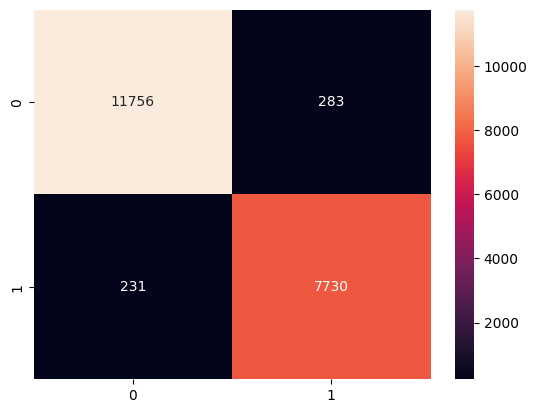

4. Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     12039
           1       0.96      0.97      0.97      7961

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000
 

5. ROC Curve & AUC Scores:



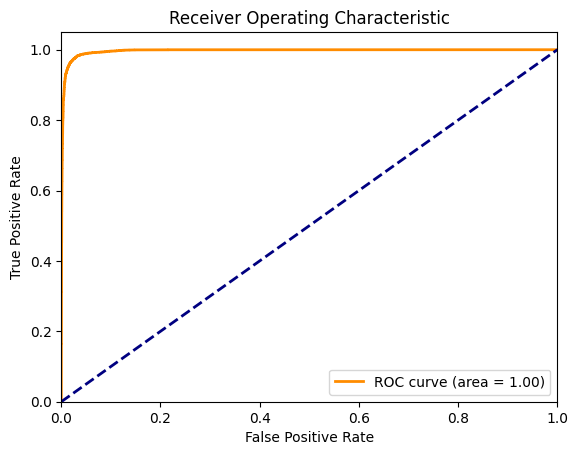

AUC Score: 1.00


In [18]:
classifier = xgb_model(X_train, X_test, y_train, y_test)

# Total time taken -> 357 minutes 5.0 seconds

# 0 -> No jail was given
# 1 -> jail was given

##### Exporting Model:

In [19]:
dump(classifier, 'xgb_model_release.joblib')
#loaded_model = load('xgb_model.joblib')

['xgb_model_release.joblib']